In [109]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time

import tqdm

from numpy.typing import ArrayLike
from typing import Callable


## Sampling 1D Gaussian via MCMC using Metropolois-Hastings 

We want to sample from the 1D Guassian distribution. 
To this end, we consider the _unnormalised_ (zero centered, i.e. $\mu = 0$) Guassian distribution 

$$\rho(x) = e^{- x^2 / (2 \sigma^2)}$$

Since normalisations are hard to get right using MCMC, it is better to compute moments.
For simplicity, we focus on 

$$ \langle x^2 \rangle = \frac{\int\ \rho(x) x^2 \ dx}{\int\ \rho(x)\ dx} = \mu^2 + \sigma^2 = \sigma^2$$

Idea:
1. use MCMC to sample a bunch of points $X = \{x_i\}_{i=1}^n$ from $\rho$ 
2. compute $\mathbb E[x^2] = \frac{1}{n} \sum_i x_i^2$

In [45]:
def rho(x:ArrayLike,mu:float = 0,sigma:float = 1) -> ArrayLike:
    """
    Unnormalised Gaussian distribution

    :param x: x variable
    :type x: ArrayLike

    :param mu: mean
    :type mu: float

    :param sigma: standard deviation
    :type sigma: float

    :returns: Gaussian N(mu,sigma)
    :rtype: ArrayLike
    """
    return np.exp( - (x - mu)**2 / (2*sigma**2) )
    
def MCMC(xi:float,rho,N:int,burnin:int,k:int,eps:float = 1) -> tuple[np.ndarray,float,np.ndarray]:
    """
    Metropolis–Hastings to compute transition probabilities T for a 1D Markov Chain Monte Carlo (MCMC)

    :param xi: initial state x(i)
    :type xi: float

    :param rho: (possibly unnormalised) probability mass function / probability distribution
    :type rho: function

    :param N: number of Monte Carlo steps
    :type N: int

    :param burnin: length of burn in phase
    :type burnin: int

    :param k: consider only each kth sample to mitigate correlations
    :type k: int

    :returns: Markov Chain sampled from rho and the acceptence rate
    :rtype: tuple[np.ndarray,float]
    """

    x = np.array([xi])
    accepted = 0
    sigma = np.array([])

    for _ in range(N):
        #PROPOSE NEXT STATE 
        xold = x[-1]
        xnew = xold + np.random.normal(loc=0,scale=eps)
        
        A = min(1,rho(xnew)/rho(xold)) # acceptence probability 
        
        p = np.random.uniform(low=0,high=1) # uniform rnd number in [0,1]

        if p <= A:
            accepted += 1
            x = np.append(x,xnew)
        else:
            x = np.append(x,xold) 

        sigma = np.append(sigma,np.mean(x**2)) 

    samples = x[burnin::k] # first 'burnin' points are "burn in", then take only each kth point

    return (samples, accepted / N, sigma)

### Vanilla Gaussian

In [46]:
# SAMPLE DISTRIBUTION rho
x, accepted, sigma = MCMC(xi=0,rho=rho,N=10_000,burnin=100,k=5)

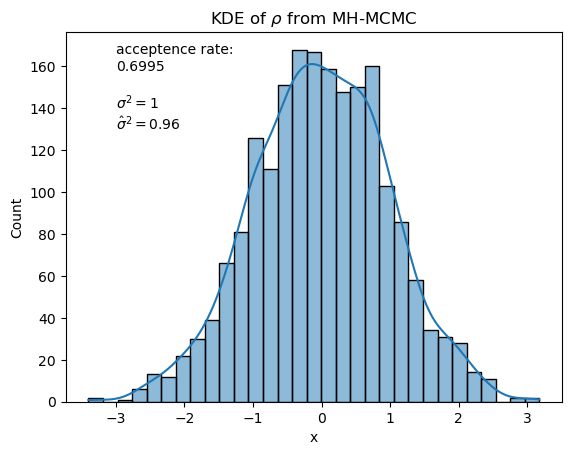

In [ ]:
# PLOT ESTIMATED PDF FROM SAMPLED DISTTRIBUTION
xs = pd.Series(x,name='x') 
sigma_hat = np.mean(x**2)

sns.histplot(data=xs,kde=True)
plt.text(-3,130,f'acceptence rate:\n{accepted}\n\n$\sigma^2 = 1$\n$\hat\sigma^2={sigma_hat:.2f}$')
plt.title(r'KDE of $\rho$ from MH-MCMC');


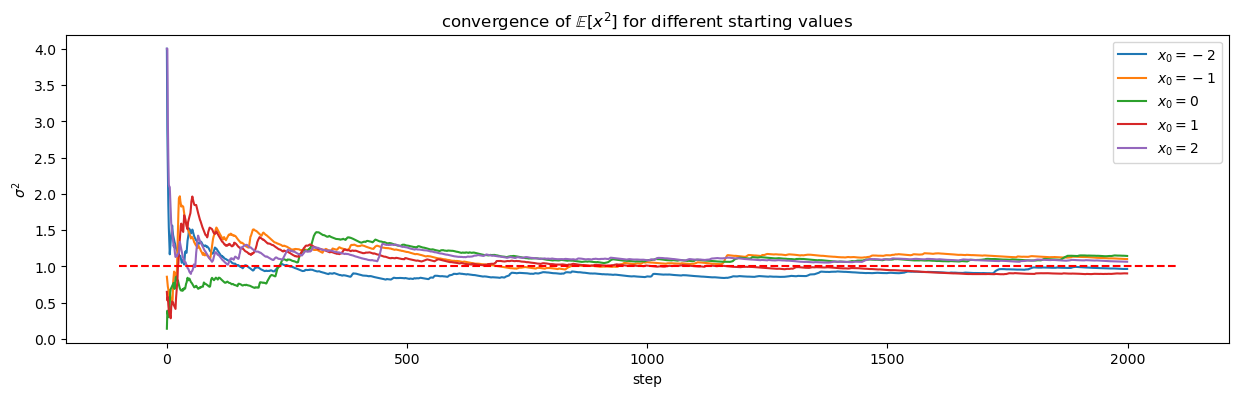

In [3]:
# CONVERGENCE OF E[x^2] FOR DIFFERENT STARTING VALUES xi
xs = []
sigmas = []
for i in range(5):
    xi = i - 2
    x, accepted, sigma = MCMC(xi=xi,rho=rho,N=2_000,burnin=100,k=5)
    xs.append(x)
    sigmas.append(sigma)


# PLOT 
fig, ax = plt.subplots(figsize=(15,4))

plt.ylabel(r'$\sigma^2$')
plt.xlabel('step')
plt.title(r'convergence of $\mathbb{E}[x^2]$ for different starting values');

for i in range(5):
    ax.plot(sigmas[i],label=f'$x_0 = {i - 2}$')

ax.hlines(y=1,xmin=-100,xmax=len(sigmas[0])+100,color='red',ls='--')
plt.legend()

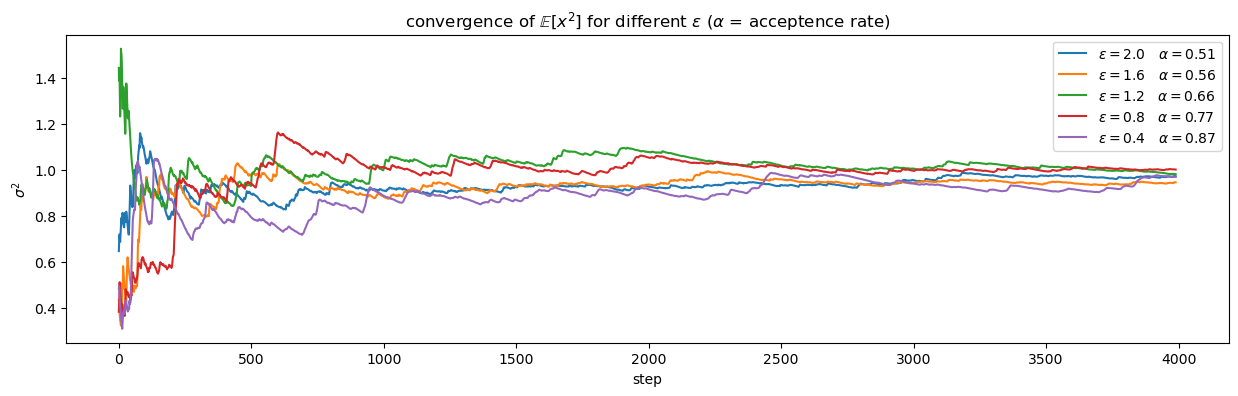

In [97]:
# CONVERGENCE OF E[x^2] FOR DIFFERENT sigma IN rho
xs = []
sigmas = []
alpha = [] # acceptence rates
for i in range(5):
    eps = 2 - 4*i/10
    x, accepted, sigma = MCMC(xi=xi,rho=lambda x: rho(x=x),N=4_000,burnin=100,k=5,eps=eps)
    xs.append(x)
    sigmas.append(sigma)
    alpha.append(accepted)


# PLOT 
fig, ax = plt.subplots(figsize=(15,4))

plt.ylabel(r'$\sigma^2$')
plt.xlabel('step')
plt.title(r'convergence of $\mathbb{E}[x^2]$ for different $\epsilon$ ($\alpha$ = acceptence rate)');

for i in range(5):
    ax.plot(sigmas[i][10:],label=f'$\epsilon = {2 - 4*i/10:.1f} \quad \\alpha = {alpha[i]:.2f}$')

plt.legend(loc='upper right');

### Sum of Gaussians

In [ ]:
# DEFINE SUM OF 2 GAUSSIANS
f = lambda x: rho(x) + 0.5*rho(x,mu=4,sigma=1.5)

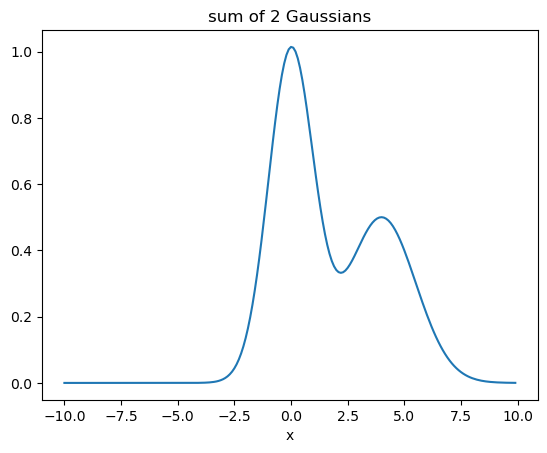

In [ ]:
# PLOT
x = np.arange(-10,10,0.1)
y = f(x)

plt.plot(x,y)
plt.title('sum of 2 Gaussians')
plt.xlabel('x')
plt.show()

In [ ]:
import scipy.integrate as integrate

In [ ]:
# SAMPLE DISTRIBUTION rho
x, accepted, sigma = MCMC(xi=0,rho=f,N=100_000,burnin=100,k=5)

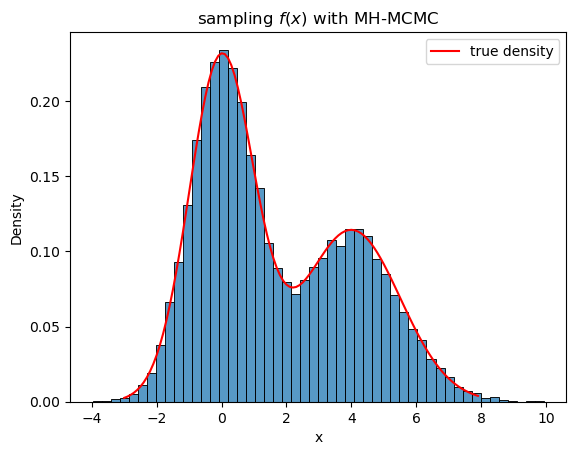

In [64]:

# PLOT ESTIMATED PDF FROM SAMPLED DISTTRIBUTION
xs = pd.Series(x,name='x') 
# sigma_hat = np.mean(x**2)
# PLOT
X = np.arange(-3,8,0.1)
y = f(X)

N = integrate.quad(f,-3,8)[0] # Normalisation for visual puproses 
y /= N


fig,ax = plt.subplots()

sns.histplot(data=xs,ax=ax,stat='density')
ax.plot(X,y,'r',label='true density')
ax.legend()

# plt.text(-3,130,f'acceptence rate:\n{accepted}\n\n$\sigma^2 = 1$\n$\hat\sigma^2={sigma_hat:.2f}$')
plt.title(r'sampling $f(x)$ with MH-MCMC');

## 2D Example: Sum of 2 Gaussians

In [3]:
def rho2D(x:np.ndarray,C:np.ndarray = None, mu:np.ndarray = None) -> ArrayLike:
    """
    Unnormalised 2D Gaussian distribution

    :param x: array of column vectors of shape (samples, d , 1)
    :type x: ArrayLike

    :param mu: mean vector 
    :type mu: np.ndarray

    :param C: covariance matrix (positive semi-definite matrix)
    :type Sigma: np.ndarray

    :returns: Gaussian N(mu,sigma)
    :rtype: ArrayLike
    """
    d = x.shape[1] # dimension of input

    if mu is None:
        mu = np.zeros(shape=x.shape)

    if C is None:
        C = np.eye(d)

    # X = x[:,:,np.newaxis] # cast x (-1,2) into (-1,2,1) => array of column vectors
    y = x - mu

    yy = ( 
        y.transpose(0,2,1) @ (C @ y) 
        ).flatten()
    
    return np.exp( - yy / 2 )

In [4]:
C = np.array([[4,2],[2,3]])
mu1 = np.array([[-1],[-1]])
mu2 = np.array([[2],[2]])

x = np.linspace(-4,4,100)
y = np.linspace(-4,4,100)

xx, yy = np.meshgrid(x,y)

X = np.c_[xx.ravel(), yy.ravel()]
X = X[:,:,np.newaxis]

data = rho2D(x=X,mu=mu1) + rho2D(x=X,C=C,mu=mu2)


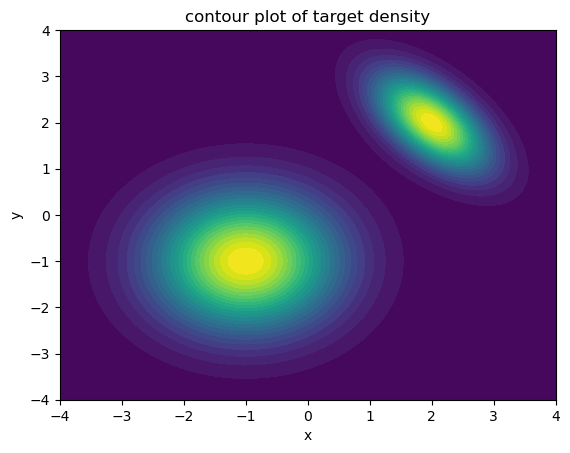

In [5]:
plt.contourf(xx,yy,data.reshape(xx.shape),levels=30)
plt.title('contour plot of target density')
plt.xlabel('x')
plt.ylabel('y');

In [ ]:
def MCMC2D_TO_CHECK(xi:float,rho,N:int,burnin:int,k:int) -> tuple[np.ndarray,float,np.ndarray]:
    """
    Metropolis–Hastings to compute transition probabilities T for a 1D Markov Chain Monte Carlo (MCMC)

    :param xi: initial state x(i)
    :type xi: float

    :param rho: (possibly unnormalised) probability mass function / probability distribution
    :type rho: function

    :param N: number of Monte Carlo steps
    :type N: int

    :param burnin: length of burn in phase
    :type burnin: int

    :param k: consider only each kth sample to mitigate correlations
    :type k: int

    :returns: samples , acceptence rate 
    :rtype: tuple[np.ndarray,float]
    """

    # INITIAL STATES ALONG x AND y AXIS
    x = [xi] # array of initial condition (d-dim column vector)
    d = xi.shape[0] # dimension

    alpha = 0

    for _ in range(N):
        #PROPOSE NEXT STATE 

        xold = x[-1] # current state (column vector, shape (2,1) )

        xnew = xold + np.random.normal(loc=0,scale=1,size=xold.shape) # proposed next state (column vector, shape (2,1) )
        
        # ACCEPTENCE PROBABILITIES
        A = np.minimum(1, rho(xnew[np.newaxis,:,:]) / (rho(xold[np.newaxis,:,:]) + 1e-10) ) # rho takes arrays of shape (# samples,2,1)
        # !!! A.shape = (1,) 
        # SHOULD NOT WORK!
        # NEED LOOP!

        # CHECK IF ACCEPTED
        p = np.random.uniform(low=0,high=1,size=d) # draw vector of uniform rnds
        # print(f'{p.shape=}\n')
        
        accepted = p < A # accept if p < A
        # print(f'{accepted=}')

        # print(f'{xnew=}')
        xnew = np.where(accepted, xnew.ravel(), xold.ravel()).reshape(d,1)
        # print(f'{xnew=}\n')
        
       
        x.append(xnew)
        alpha += np.sum(accepted)

    samples = np.array(x)[burnin::k]

    acception_rate = alpha / (d*N) 

    return (samples, acception_rate)

In [85]:
def MCMCdD(xi:float,rho,N:int,burnin:int,k:int) -> tuple[np.ndarray,float,np.ndarray]:
    """
    Metropolis–Hastings to compute d-dimensional Markov Chain Monte Carlo (MCMC)

    :param xi: initial state x_i (list of  (d,1) (column) vectors)
    :type xi: float

    :param rho: (possibly unnormalised) probability mass function / probability distribution
    :type rho: function

    :param N: number of Monte Carlo steps
    :type N: int

    :param burnin: length of burn in phase
    :type burnin: int

    :param k: consider only each kth sample to mitigate correlations
    :type k: int

    :returns: (samples , acceptence rate)
    :rtype: tuple[np.ndarray,float]
    """

    # INITIAL STATES ALONG x AND y AXIS
    x = [xi] # array of initial condition (d-dim column vector)
    d = xi.shape[0] # dimension

    alpha = 0

    for _ in range(N):

        # LOOP OVER COMPONENTS 
        for j in range(d):

            xold = x[-1] # current state (column vector, shape (2,1) )

            #PROPOSE NEXT STATE 
            xnew = xold.copy()
            xnew[j] = xold[j] + np.random.normal(loc=0,scale=1) 
        
            # ACCEPTENCE PROBABILITIES
            A = np.minimum(1, rho(xnew[np.newaxis,:,:]) / (rho(xold[np.newaxis,:,:]) + 1e-10) ) # rho takes arrays of shape (# samples,2,1)
    
            # CHECK IF ACCEPTED
            p = np.random.uniform(low=0,high=1) # draw vector of uniform rnds
            
            if p <= A : # accept if p < A
                x.append(xnew)
                alpha += 1
            else:
                x.append(xold)
       
    samples = np.array(x)[burnin::k]

    acception_rate = alpha / (d*N) 

    return (samples, acception_rate)

In [94]:
C = np.array([[1.1,1],[1,1]])
mu1 = np.array([[3],[3]])
mu2 = np.array([[0],[0]])

x = np.linspace(-6,6,100)
y = np.linspace(-6,6,100)

xx, yy = np.meshgrid(x,y)

X = np.c_[xx.ravel(), yy.ravel()]
X = X[:,:,np.newaxis]

f = lambda x: rho2D(x=x,mu=mu1) + rho2D(x=x,C=C,mu=mu2)
# f = lambda x: rho2D(x=x,C=C,mu=mu2)

data = f(X)

In [95]:
xi = np.array([0.0,0.0]).reshape(2,1)

N_steps = 100_000

t0 = time.time()

samples, alpha = MCMCdD(xi=xi,rho=f,N=N_steps,burnin=100,k=5)

print(f'runtime with {N_steps:_d} steps: {time.time()-t0:.2f}s')
print(f'acceptence rate: {alpha}')

runtime with 100_000 steps: 4.64s
acceptence rate: 0.705815


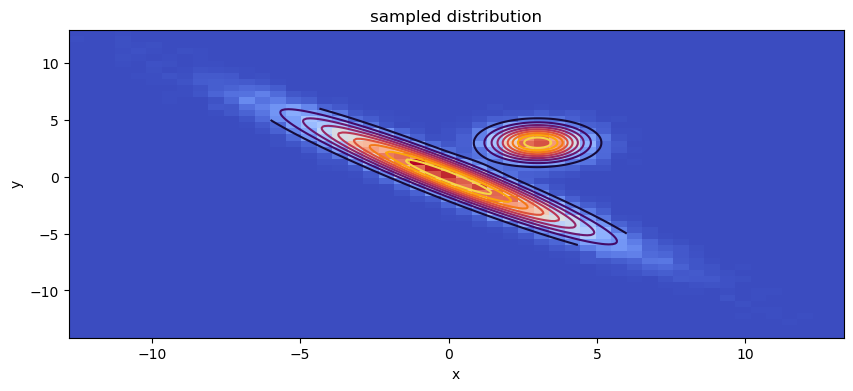

In [106]:
fig = plt.figure(figsize=(10,4))

sampled_data = samples.squeeze()

plt.contour(xx,yy,data.reshape(xx.shape),levels=10,cmap='inferno')
plt.hist2d(x = sampled_data[:,0], y = sampled_data[:,1],bins=50,cmap='coolwarm')
plt.title('sampled distribution')
plt.xlabel('x')
plt.ylabel('y');


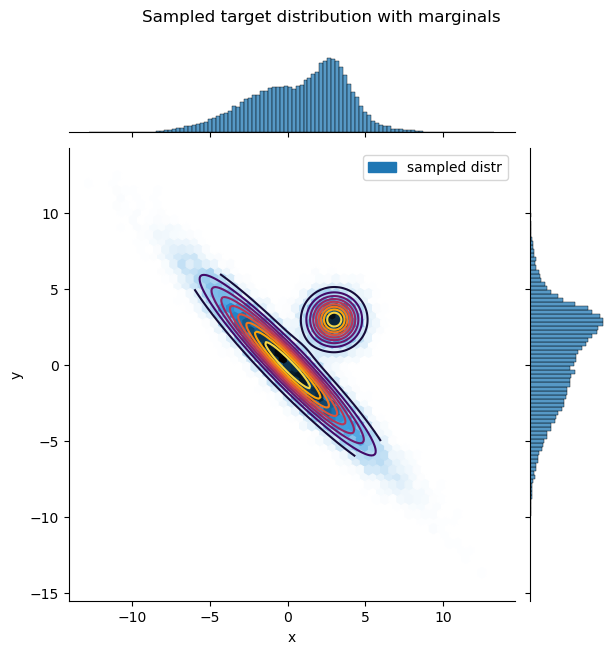

In [105]:
sns.jointplot(x = sampled_data[:,0], y = sampled_data[:,1],kind='hex',label='sampled distr')
plt.contour(xx,yy,data.reshape(xx.shape),levels=10,cmap='inferno')
plt.suptitle('Sampled target distribution with marginals',y=1.05)
plt.xlabel('x')
plt.ylabel('y')
plt.legend();

## A Lattice Example

Model:

$$S = \sum_{x \in \Lambda} (1 - 2 \lambda)\phi^2(x) + \lambda \phi^4(x) - 2 \kappa \sum_{\mu = 1}^D \phi(x)\phi(x + a \hat\mu)$$

critical couplings:
* $(\kappa,\lambda) ~ (0.276,0.03)$

Took inspiration from: [click here](https://github.com/julian-urban/lattice-phi4/tree/master)

In [243]:
# ACTION
def S(phi:np.ndarray, lam:float, kappa:float):
    """
    Parameters:
    -----------
    phi: np.ndarray
        field evaluated on lattice
    lam: float
        coupling constant
    kappa: float
        coupling constant

    Returns:
    --------
    S: float
        action functional evaluated on lattice
    """
    S_ = (1 - 2*lam)*phi[x]**2 + lam*phi[x]**4 
    
    for mu in range(2): # 2d lattice
        S_ += - 2 * kappa * phi * np.roll(phi,1,mu)
    
    return S_.sum()




In [335]:
def metropolis(lattice:np.ndarray,phi:list,S:Callable):
    alpha_ = 0

    # LOOP OVER COMPONENTS 
    for x in lattice:

        #PROPOSE NEXT STATE 
        phi_new = phi.copy()
        phi_new[x] = phi[x] + np.random.normal(loc=0,scale=1) 
    
        # ACCEPTENCE PROBABILITIES
        Acc = np.minimum(1, S(phi_new) / (S(phi)) ) # S assumes single argument

        # CHECK IF ACCEPTED
        p = np.random.uniform(low=0,high=1) # draw vector of uniform rnds
        
        if p <= Acc : # accept if p < Acc
            phi[x] = phi_new[x]
            alpha_ += 1

    return alpha_ / len(lattice)

100%|██████████| 10000/10000 [00:20<00:00, 487.13it/s]


alpha = 0.9997046874999105


Text(0.5, 1.0, 'Magnetization (per lattice site)')

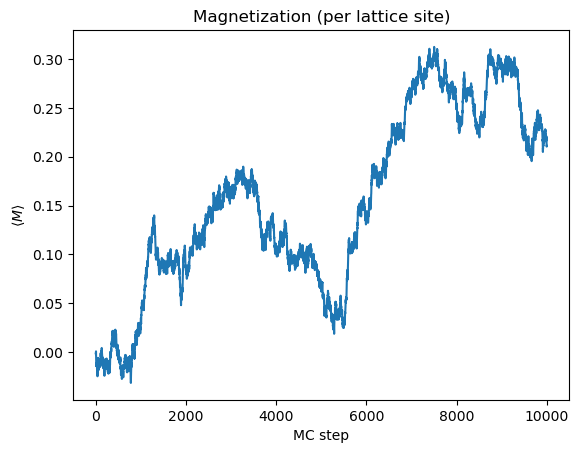

In [347]:
# INTEGRAL LATTICE
D = 8
lattice = list(np.ndindex(D,D)) # tuple, 2d lattice coordinates

# PHYS PARAMS
phi = np.random.randn(D,D) # initial rnd state
kappa = 0.276 # crit coupling
lam = 0.03  # crit coupling
A = lambda phi: S(phi,lam=lam,kappa=kappa) # action functional
M = [] # magnetization 

# MCMC PARAMS
N = 10_000
alpha = 0. # acceptence rate

# MCMC 
for _ in tqdm.tqdm(range(N)):
    alpha += metropolis(lattice=lattice, phi=phi, S=A) / N
    M.append(phi.mean()/len(lattice))


print(f'\n{alpha = }')

plt.plot(M)
plt.ylabel(r'$\langle M \rangle$')
plt.xlabel('MC step')
plt.title('Magnetization (per lattice site)');

    

## QUSTIONS


1. sweep only for (1,0), (0,1) or also for (-1,0), (0, -1)?

2. lattice spacing?

3. why does alpha += ... / N not work? diferent than alpha += ... then at the end print  alpha / N


## MISC / TESTS

In [181]:
foo = np.array([[1,2,3],[4,5,6],[7,8,9]])
foo

array([[1, 2, 3],
       [4, 5, 6],
       [7, 8, 9]])

In [187]:
for axis in range(2):
    print(np.roll(foo,-1,axis))
    print('')

[[4 5 6]
 [7 8 9]
 [1 2 3]]

[[2 3 1]
 [5 6 4]
 [8 9 7]]

